## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load sector stocks and performance data from EDA
sector_df = pd.read_csv('sector_stocks.csv')
performance_df = pd.read_csv('stock_performance_summary.csv')

print(f"Loaded {len(sector_df)} stocks")
print(f"Performance data for {len(performance_df)} stocks")
performance_df.head()

Loaded 302 stocks
Performance data for 302 stocks


,Symbol,Annual_Return,Volatility,Sharpe_Ratio,Total_Return,Sector,Sector_Code
0,HWM,0.752841,0.343577,2.074764,2.952448,Industrial,XLI
1,BK,0.438942,0.208855,1.910140,1.282856,Financial,XLF
2,GE,0.626070,0.306908,1.909598,2.142941,Industrial,XLI
3,WDC,0.970946,0.501804,1.855199,4.323454,Technology,XLK
4,TPR,0.760551,0.390915,1.843242,2.869429,Consumer Discretionary,XLY


In [3]:
# Load cached price data
price_data = pd.read_pickle('price_data_all_stocks_cache.pkl')
print(f"Price data shape: {price_data.shape}")
print(f"Date range: {price_data.index[0]} to {price_data.index[-1]}")

Price data shape: (500, 1505)
Date range: 2024-01-12 00:00:00 to 2026-01-09 00:00:00


## 2. Fetch Fundamental Data

Download key financial metrics for all stocks including:
- Revenue & Revenue Growth
- Earnings (EPS) & Earnings Growth
- Profit Margins
- Market Cap
- P/E Ratio, P/B Ratio
- Debt-to-Equity
- ROE, ROA

In [4]:
# Configuration
USE_SAMPLE = False  # Set to False to fetch for all stocks (takes longer)
SAMPLE_SIZE = 50  # Number of stocks to sample for faster testing

# Stocks to exclude (no data available)
EXCLUDED_STOCKS = ['ANSS', 'CTLT', 'DFS', 'JNPR', 'TPX']

if USE_SAMPLE:
    # Sample stocks proportionally from each sector
    stocks_to_analyze = []
    for sector in sector_df['Sector_Code'].unique():
        sector_stocks = sector_df[sector_df['Sector_Code'] == sector]['Symbol'].head(10).tolist()
        # Filter out excluded stocks
        sector_stocks = [s for s in sector_stocks if s not in EXCLUDED_STOCKS]
        stocks_to_analyze.extend(sector_stocks)
    print(f"Using sample of {len(stocks_to_analyze)} stocks for analysis")
else:
    stocks_to_analyze = sector_df['Symbol'].tolist()
    # Filter out excluded stocks
    stocks_to_analyze = [s for s in stocks_to_analyze if s not in EXCLUDED_STOCKS]
    print(f"Using all {len(stocks_to_analyze)} stocks for analysis")
    print(f"Excluded {len(EXCLUDED_STOCKS)} stocks with missing data: {EXCLUDED_STOCKS}")

Using all 302 stocks for analysis
Excluded 5 stocks with missing data: ['ANSS', 'CTLT', 'DFS', 'JNPR', 'TPX']


In [5]:
# Function to fetch fundamental data for a stock
def get_stock_fundamentals(ticker):
    """Fetch key fundamental metrics for a stock"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        fundamentals = {
            'Symbol': ticker,
            'Market_Cap': info.get('marketCap', np.nan),
            'PE_Ratio': info.get('trailingPE', np.nan),
            'Forward_PE': info.get('forwardPE', np.nan),
            'PB_Ratio': info.get('priceToBook', np.nan),
            'PS_Ratio': info.get('priceToSalesTrailing12Months', np.nan),
            'Profit_Margin': info.get('profitMargins', np.nan),
            'Operating_Margin': info.get('operatingMargins', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'ROA': info.get('returnOnAssets', np.nan),
            'Debt_to_Equity': info.get('debtToEquity', np.nan),
            'Current_Ratio': info.get('currentRatio', np.nan),
            'Revenue': info.get('totalRevenue', np.nan),
            'Revenue_Growth': info.get('revenueGrowth', np.nan),
            'Earnings_Growth': info.get('earningsGrowth', np.nan),
            'EPS': info.get('trailingEps', np.nan),
            'Beta': info.get('beta', np.nan),
            'Dividend_Yield': info.get('dividendYield', np.nan),
            '52W_High': info.get('fiftyTwoWeekHigh', np.nan),
            '52W_Low': info.get('fiftyTwoWeekLow', np.nan),
        }
        return fundamentals
    except Exception as e:
        print(f"Error fetching {ticker}: {str(e)}")
        return {'Symbol': ticker}

print("Fundamental data fetching function defined")

Fundamental data fetching function defined


In [6]:
# Check for cached fundamentals
import os
from datetime import datetime, timedelta

fundamentals_cache = 'fundamentals_data_cache.pkl'

# Define cache validity period (7 days)
CACHE_VALIDITY_DAYS = 7

cache_is_valid = False

if os.path.exists(fundamentals_cache):
    print(f"Found cached fundamentals file '{fundamentals_cache}'. Checking freshness...")
    
    # Check file modification time
    file_mod_time = datetime.fromtimestamp(os.path.getmtime(fundamentals_cache))
    current_time = datetime.now()
    days_old = (current_time - file_mod_time).days
    
    print(f"Cache file last modified: {file_mod_time.strftime('%Y-%m-%d')}")
    print(f"Cache is {days_old} days old")
    
    if days_old <= CACHE_VALIDITY_DAYS:
        cache_is_valid = True
        print(f"✓ Cache is fresh (less than {CACHE_VALIDITY_DAYS} days old). Using cached data.")
        fundamentals_df = pd.read_pickle(fundamentals_cache)
        print(f"Loaded {len(fundamentals_df)} stocks with fundamentals")
    else:
        print(f"⚠ Cache is stale (more than {CACHE_VALIDITY_DAYS} days old). Will re-fetch data.")

if not cache_is_valid:
    print("Fetching fundamental data for all stocks...")
    print("This may take several minutes...\n")
    
    fundamentals_list = []
    for i, ticker in enumerate(stocks_to_analyze, 1):
        if i % 10 == 0:
            print(f"Progress: {i}/{len(stocks_to_analyze)} stocks processed")
        fundamentals = get_stock_fundamentals(ticker)
        fundamentals_list.append(fundamentals)
    
    fundamentals_df = pd.DataFrame(fundamentals_list)
    
    # Save cache
    fundamentals_df.to_pickle(fundamentals_cache)
    print(f"\nFundamentals cached to '{fundamentals_cache}'")

print(f"\nFundamentals data shape: {fundamentals_df.shape}")
fundamentals_df.head()

Found cached fundamentals file 'fundamentals_data_cache.pkl'. Checking freshness...
Cache file last modified: 2025-12-07
Cache is 35 days old
⚠ Cache is stale (more than 7 days old). Will re-fetch data.
Fetching fundamental data for all stocks...
This may take several minutes...

Progress: 10/302 stocks processed
Progress: 20/302 stocks processed
Progress: 30/302 stocks processed
Progress: 40/302 stocks processed
Progress: 50/302 stocks processed
Progress: 60/302 stocks processed
Progress: 70/302 stocks processed
Progress: 80/302 stocks processed
Progress: 90/302 stocks processed
Progress: 100/302 stocks processed
Progress: 110/302 stocks processed
Progress: 120/302 stocks processed
Progress: 130/302 stocks processed
Progress: 140/302 stocks processed
Progress: 150/302 stocks processed
Progress: 160/302 stocks processed
Progress: 170/302 stocks processed
Progress: 180/302 stocks processed
Progress: 190/302 stocks processed
Progress: 200/302 stocks processed
Progress: 210/302 stocks pro

,Symbol,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,Debt_to_Equity,Current_Ratio,Revenue,Revenue_Growth,Earnings_Growth,EPS,Beta,Dividend_Yield,52W_High,52W_Low
0,AAPL,3832542658560,34.721554,28.341707,51.967537,9.209279,0.26915,0.31647,1.71422,0.22964,152.411,0.893,416161005568,0.079,0.912,7.47,1.093,0.40,288.62,169.21
1,MSFT,3562567892992,34.136753,25.571993,9.813268,12.125331,0.35707,0.48873,0.32241,0.14656,33.154,1.401,293812011008,0.184,0.127,14.04,1.073,0.76,555.45,344.79
2,NVDA,4499934543872,45.635800,24.364536,37.781070,24.045563,0.53007,0.63169,1.07359,0.53528,9.102,4.468,187141996544,0.625,0.667,4.05,2.314,0.02,212.19,86.62
3,AVGO,1635597156352,72.472690,24.494170,5.825130,25.601408,0.36198,0.31765,0.31048,0.09788,166.032,1.705,63886999552,0.164,1.881,4.76,1.218,0.75,414.61,138.10
4,CRM,247462887424,34.704940,19.814840,4.079602,6.137929,0.17913,0.23862,0.12184,0.05950,19.385,0.984,40317001728,0.086,0.386,7.49,1.266,0.64,367.09,221.96


In [7]:
# Merge with sector information
fundamentals_df = fundamentals_df.merge(sector_df[['Symbol', 'Sector', 'Sector_Code']], on='Symbol', how='left')

# Check missing data
print("Missing data summary:")
missing_pct = (fundamentals_df.isnull().sum() / len(fundamentals_df) * 100).sort_values(ascending=False)
print(missing_pct[missing_pct > 0])

print(f"\nTotal stocks with fundamentals: {len(fundamentals_df)}")
fundamentals_df.describe()

Missing data summary:
Dividend_Yield     23.026316
Debt_to_Equity     14.802632
Earnings_Growth     8.881579
ROE                 7.236842
Current_Ratio       6.250000
PE_Ratio            4.934211
Revenue_Growth      0.657895
Beta                0.657895
ROA                 0.328947
dtype: float64

Total stocks with fundamentals: 304


,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,Debt_to_Equity,Current_Ratio,Revenue,Revenue_Growth,Earnings_Growth,EPS,Beta,Dividend_Yield,52W_High,52W_Low
count,3.040000e+02,289.000000,304.000000,304.000000,304.000000,304.000000,304.000000,282.000000,303.000000,259.00000,285.000000,3.040000e+02,302.000000,277.000000,304.000000,302.000000,234.000000,304.000000,304.000000
mean,1.406785e+11,34.155396,21.808718,1.084778,4.908605,0.146146,0.222113,0.285535,0.075337,141.59439,1.730930,3.588537e+10,0.099609,0.246527,10.809803,1.066411,1.746154,339.371536,211.902807
std,4.425079e+11,31.373921,16.376056,64.001002,4.465408,0.146351,0.139789,0.499682,0.065861,324.06529,1.365479,7.207896e+10,0.165578,0.868717,29.304400,0.411372,1.241628,676.194129,490.711235
min,2.550274e+09,6.883231,-4.919834,-1030.542500,0.136627,-1.396060,-0.255910,-0.628390,-0.154940,0.52800,0.165000,8.392630e+08,-0.454000,-0.903000,-24.000000,0.049000,0.020000,12.790000,6.850000
25%,2.278862e+10,18.519140,13.650395,1.906799,1.976726,0.080210,0.119582,0.101537,0.038120,31.21950,0.996000,6.929344e+09,0.036250,-0.041000,3.067500,0.800750,0.855000,104.507500,62.837500
50%,4.700878e+10,26.396166,19.217300,4.047766,3.747802,0.139365,0.198550,0.175710,0.062520,70.03700,1.358000,1.421000e+10,0.076000,0.108000,6.570000,1.070500,1.480000,219.490000,122.065000
75%,1.016127e+11,36.002580,25.103950,8.409975,5.999354,0.212232,0.316472,0.319428,0.097820,130.93850,2.024000,2.919813e+10,0.123750,0.294000,11.792500,1.314000,2.297500,351.620000,220.712500
max,4.499935e+12,302.727900,203.831040,167.463130,25.988100,0.712200,0.678360,5.638710,0.535280,4217.21100,12.398000,6.913300e+11,2.026000,9.314000,454.900000,2.516000,6.750000,8618.280000,6562.850000


## 3. Feature Engineering

Create technical indicators and derived features

In [8]:
# Extract Close prices for feature engineering
print("Extracting price data...")
print(f"Price data shape: {price_data.shape}")

# The data has MultiIndex columns: (Price Type, Ticker)
# Most stocks have 'Close', but some problematic stocks only have 'Adj Close' (all NaN)
# We'll use 'Close' data and exclude the 5 stocks that only have 'Adj Close'

if isinstance(price_data.columns, pd.MultiIndex):
    # Get all stocks that have 'Close' data (the good stocks)
    if 'Close' in price_data.columns.get_level_values(0):
        adj_close = price_data.xs('Close', level=0, axis=1)
        print(f" Extracted 'Close' price data")
    elif 'Adj Close' in price_data.columns.get_level_values(0):
        adj_close = price_data.xs('Adj Close', level=0, axis=1)
        print(f" Extracted 'Adj Close' price data")
    else:
        raise ValueError("Could not find 'Close' or 'Adj Close' in price data!")
else:
    # If not MultiIndex, use data as-is
    adj_close = price_data
    print(" Using price data as-is (not MultiIndex)")

print(f"\nExtracted data shape: {adj_close.shape}")
print(f"Total stocks available: {len(adj_close.columns)}")

# Remove any columns with all NaN values (failed downloads)
nan_counts = adj_close.isna().sum()
all_nan_stocks = nan_counts[nan_counts == len(adj_close)].index.tolist()

if all_nan_stocks:
    print(f"\nRemoving {len(all_nan_stocks)} stocks with all NaN values: {all_nan_stocks}")
    adj_close = adj_close.drop(columns=all_nan_stocks)

print(f"\nFinal data shape: {adj_close.shape}")
print(f"Stocks ready for analysis: {len(adj_close.columns)}")
print(f"Sample stocks: {adj_close.columns[:10].tolist()}")

adj_close.head()

Extracting price data...
Price data shape: (500, 1505)
 Extracted 'Close' price data

Extracted data shape: (500, 301)
Total stocks available: 301

Final data shape: (500, 301)
Stocks ready for analysis: 301
Sample stocks: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADP']


Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADP,...,WHR,WM,WRB,WST,WTW,XRAY,XYL,YUM,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-12,128.605194,184.180603,152.826035,137.139999,110.143608,73.875305,345.756042,596.539978,182.213074,225.874664,...,100.394737,176.212646,46.136833,344.824554,242.609558,33.971375,109.205437,124.205788,248.869995,194.405548
2024-01-16,128.595337,181.912033,151.960281,135.020004,109.988922,74.331734,344.038574,597.679993,181.661682,225.233261,...,99.049232,175.600647,46.447327,344.556122,240.060379,33.404564,108.452835,124.859856,243.520004,188.591156
2024-01-17,126.221062,180.970917,152.487259,134.979996,110.153282,74.807182,344.408630,596.099976,179.378693,225.338562,...,98.565536,176.280655,46.719799,337.605316,241.310547,33.005016,107.211525,124.157707,239.169998,186.548782
2024-01-18,128.526382,186.865234,153.672974,137.039993,110.240303,75.082947,350.154449,593.700012,183.770554,225.999069,...,98.838165,178.262314,47.131676,340.946442,241.994232,33.367397,108.882896,125.485077,249.589996,186.580139
2024-01-19,129.275146,189.767838,155.056320,139.929993,110.888084,76.908669,354.390808,611.549988,188.413910,228.066879,...,99.040436,179.175415,47.727322,340.817169,244.914520,33.135101,109.342270,127.254921,249.089996,184.503769


In [9]:
# Function to calculate technical indicators
def calculate_technical_features(prices, ticker):
    """Calculate technical indicators for a stock"""
    if ticker not in prices.columns:
        return {}
    
    price_series = prices[ticker].dropna()
    
    if len(price_series) < 50:
        return {'Symbol': ticker}
    
    features = {'Symbol': ticker}
    
    # Moving averages
    features['MA_20'] = price_series.rolling(20).mean().iloc[-1]
    features['MA_50'] = price_series.rolling(50).mean().iloc[-1]
    features['MA_200'] = price_series.rolling(200).mean().iloc[-1] if len(price_series) >= 200 else np.nan
    
    # Current price relative to moving averages
    current_price = price_series.iloc[-1]
    features['Price_to_MA20'] = current_price / features['MA_20'] if features['MA_20'] > 0 else np.nan
    features['Price_to_MA50'] = current_price / features['MA_50'] if features['MA_50'] > 0 else np.nan
    
    # Momentum indicators
    features['Momentum_20'] = (price_series.iloc[-1] / price_series.iloc[-20] - 1) if len(price_series) >= 20 else np.nan
    features['Momentum_60'] = (price_series.iloc[-1] / price_series.iloc[-60] - 1) if len(price_series) >= 60 else np.nan
    
    # Volatility (standard deviation of returns)
    returns = price_series.pct_change().dropna()
    features['Volatility_20'] = returns.rolling(20).std().iloc[-1] * np.sqrt(252)
    features['Volatility_60'] = returns.rolling(60).std().iloc[-1] * np.sqrt(252)
    
    # RSI (Relative Strength Index)
    delta = price_series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    features['RSI'] = 100 - (100 / (1 + rs.iloc[-1]))
    
    # Price range
    features['52W_Range'] = (current_price - price_series.rolling(252).min().iloc[-1]) / \
                            (price_series.rolling(252).max().iloc[-1] - price_series.rolling(252).min().iloc[-1]) \
                            if len(price_series) >= 252 else np.nan
    
    return features

print("Technical features function defined")

Technical features function defined


In [10]:
# Calculate technical features for all stocks
from datetime import datetime

technical_cache = 'technical_features_cache.pkl'

# Define cache validity period (7 days)
CACHE_VALIDITY_DAYS = 7

cache_is_valid = False

if os.path.exists(technical_cache):
    print(f"Found cached technical features file '{technical_cache}'. Checking freshness...")
    
    # Check file modification time
    file_mod_time = datetime.fromtimestamp(os.path.getmtime(technical_cache))
    current_time = datetime.now()
    days_old = (current_time - file_mod_time).days
    
    print(f"Cache file last modified: {file_mod_time.strftime('%Y-%m-%d')}")
    print(f"Cache is {days_old} days old")
    
    if days_old <= CACHE_VALIDITY_DAYS:
        # Load and validate cache
        temp_df = pd.read_pickle(technical_cache)
        # Only use cache if it has actual features (more than just Symbol column)
        if temp_df.shape[1] > 1:
            cache_is_valid = True
            print(f"✓ Cache is fresh (less than {CACHE_VALIDITY_DAYS} days old). Using cached data.")
            technical_df = temp_df
        else:
            print(f"⚠ Cached file is empty or invalid. Will recalculate.")
    else:
        print(f"⚠ Cache is stale (more than {CACHE_VALIDITY_DAYS} days old). Will recalculate.")

if not cache_is_valid:
    print("Calculating technical features for all stocks...")
    print("This may take a few minutes...\n")
    
    technical_features = []
    for i, ticker in enumerate(stocks_to_analyze, 1):
        if i % 20 == 0:
            print(f"Progress: {i}/{len(stocks_to_analyze)} stocks processed")
        features = calculate_technical_features(adj_close, ticker)
        technical_features.append(features)
    
    print(f"\nProgress: {len(stocks_to_analyze)}/{len(stocks_to_analyze)} stocks processed")
    technical_df = pd.DataFrame(technical_features)
    
    # Save the new cache
    technical_df.to_pickle(technical_cache)
    print(f"✓ Technical features cached to '{technical_cache}'")

print(f"\nTechnical features shape: {technical_df.shape}")
print(f"Columns: {technical_df.columns.tolist()}")
technical_df.head()

Found cached technical features file 'technical_features_cache.pkl'. Checking freshness...
Cache file last modified: 2025-12-07
Cache is 35 days old
⚠ Cache is stale (more than 7 days old). Will recalculate.
Calculating technical features for all stocks...
This may take a few minutes...

Progress: 20/302 stocks processed
Progress: 40/302 stocks processed
Progress: 60/302 stocks processed
Progress: 80/302 stocks processed
Progress: 100/302 stocks processed
Progress: 120/302 stocks processed
Progress: 140/302 stocks processed
Progress: 160/302 stocks processed
Progress: 180/302 stocks processed
Progress: 200/302 stocks processed
Progress: 220/302 stocks processed
Progress: 240/302 stocks processed
Progress: 260/302 stocks processed
Progress: 280/302 stocks processed
Progress: 300/302 stocks processed

Progress: 302/302 stocks processed
✓ Technical features cached to 'technical_features_cache.pkl'

Technical features shape: (302, 12)
Columns: ['Symbol', 'MA_20', 'MA_50', 'MA_200', 'Price_

,Symbol,MA_20,MA_50,MA_200,Price_to_MA20,Price_to_MA50,Momentum_20,Momentum_60,Volatility_20,Volatility_60,RSI,52W_Range
0,AAPL,270.566997,272.579182,232.801001,0.958617,0.951540,-0.067115,0.041235,0.110359,0.167393,21.935218,0.765472
1,MSFT,481.504503,490.384874,478.969788,0.995380,0.977355,-0.008667,-0.064766,0.142351,0.190815,43.992826,0.672074
2,NVDA,183.677500,186.368940,162.172739,1.006438,0.991903,0.021721,0.028028,0.303922,0.344879,66.908513,0.803359
3,AVGO,346.661162,359.972618,292.709047,0.995122,0.958323,-0.149470,-0.016224,0.535435,0.478915,63.170245,0.748048
4,CRM,261.185881,250.279204,255.590275,0.995230,1.038600,-0.007587,0.100514,0.250623,0.321685,52.483949,0.263431


In [11]:
# Combine all features
# First, merge fundamentals with technical features
full_features_df = fundamentals_df.merge(technical_df, on='Symbol', how='inner')

# Check which columns are in performance_df
print("Performance DataFrame columns:", performance_df.columns.tolist())
print(f"\nStocks in fundamentals+technical: {len(full_features_df)}")
print(f"Stocks in performance_df: {len(performance_df)}")

# Find common stocks
common_stocks = set(full_features_df['Symbol']).intersection(set(performance_df['Symbol']))
print(f"Common stocks: {len(common_stocks)}")

# Merge with performance data - only include columns that exist
performance_cols_to_merge = ['Symbol']
for col in ['Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return']:
    if col in performance_df.columns:
        performance_cols_to_merge.append(col)
    else:
        print(f"Warning: '{col}' not found in performance_df")

full_features_df = full_features_df.merge(performance_df[performance_cols_to_merge], 
                                          on='Symbol', how='inner')

print(f"\nCombined features shape: {full_features_df.shape}")
print(f"Columns: {full_features_df.columns.tolist()}")
full_features_df.head()

Performance DataFrame columns: ['Symbol', 'Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return', 'Sector', 'Sector_Code']

Stocks in fundamentals+technical: 308
Stocks in performance_df: 302
Common stocks: 301

Combined features shape: (316, 37)
Columns: ['Symbol', 'Market_Cap', 'PE_Ratio', 'Forward_PE', 'PB_Ratio', 'PS_Ratio', 'Profit_Margin', 'Operating_Margin', 'ROE', 'ROA', 'Debt_to_Equity', 'Current_Ratio', 'Revenue', 'Revenue_Growth', 'Earnings_Growth', 'EPS', 'Beta', 'Dividend_Yield', '52W_High', '52W_Low', 'Sector', 'Sector_Code', 'MA_20', 'MA_50', 'MA_200', 'Price_to_MA20', 'Price_to_MA50', 'Momentum_20', 'Momentum_60', 'Volatility_20', 'Volatility_60', 'RSI', '52W_Range', 'Annual_Return', 'Volatility', 'Sharpe_Ratio', 'Total_Return']


,Symbol,Market_Cap,PE_Ratio,Forward_PE,PB_Ratio,PS_Ratio,Profit_Margin,Operating_Margin,ROE,ROA,...,Momentum_20,Momentum_60,Volatility_20,Volatility_60,RSI,52W_Range,Annual_Return,Volatility,Sharpe_Ratio,Total_Return
0,AAPL,3832542658560,34.721554,28.341707,51.967537,9.209279,0.26915,0.31647,1.71422,0.22964,...,-0.067115,0.041235,0.110359,0.167393,21.935218,0.765472,0.211486,0.279351,0.613874,0.408237
1,MSFT,3562567892992,34.136753,25.571993,9.813268,12.125331,0.35707,0.48873,0.32241,0.14656,...,-0.008667,-0.064766,0.142351,0.190815,43.992826,0.672074,0.138144,0.222343,0.441409,0.252159
2,NVDA,4499934543872,45.635800,24.364536,37.781070,24.045563,0.53007,0.63169,1.07359,0.53528,...,0.021721,0.028028,0.303922,0.344879,66.908513,0.803359,0.745193,0.509813,1.383237,2.380789
3,AVGO,1635597156352,72.472690,24.494170,5.825130,25.601408,0.36198,0.31765,0.31048,0.09788,...,-0.149470,-0.016224,0.535435,0.478915,63.170245,0.748048,0.726763,0.536143,1.280934,2.184817
4,CRM,247462887424,34.704940,19.814840,4.079602,6.137929,0.17913,0.23862,0.12184,0.05950,...,-0.007587,0.100514,0.250623,0.321685,52.483949,0.263431,0.042533,0.340775,0.007432,-0.032478


## 4. Correlation Analysis: Fundamentals vs Returns

In [12]:
# Select numeric columns for correlation analysis
numeric_cols = full_features_df.select_dtypes(include=[np.number]).columns.tolist()
correlation_df = full_features_df[numeric_cols].copy()

# Calculate correlation with returns
correlations_with_returns = correlation_df.corr()['Annual_Return'].sort_values(ascending=False)

print("Top 15 features correlated with Annual Returns:")
print(correlations_with_returns.head(15))
print("\nBottom 15 features (negatively correlated):")
print(correlations_with_returns.tail(15))

Top 15 features correlated with Annual Returns:
Annual_Return     1.000000
Total_Return      0.940248
Sharpe_Ratio      0.925819
52W_Range         0.546231
PS_Ratio          0.319408
Beta              0.295853
Revenue_Growth    0.292907
Volatility_20     0.274208
Momentum_60       0.272184
Profit_Margin     0.245673
Forward_PE        0.231088
Volatility_60     0.210801
Market_Cap        0.209865
Volatility        0.202648
PE_Ratio          0.195107
Name: Annual_Return, dtype: float64

Bottom 15 features (negatively correlated):
Price_to_MA20     0.080355
MA_20             0.069609
MA_50             0.066368
Revenue           0.063043
Momentum_20       0.061204
ROA               0.055074
52W_High          0.048171
ROE               0.036844
MA_200            0.034965
Debt_to_Equity    0.018887
EPS               0.015173
52W_Low          -0.001454
Current_Ratio    -0.082546
PB_Ratio         -0.104738
Dividend_Yield   -0.326273
Name: Annual_Return, dtype: float64


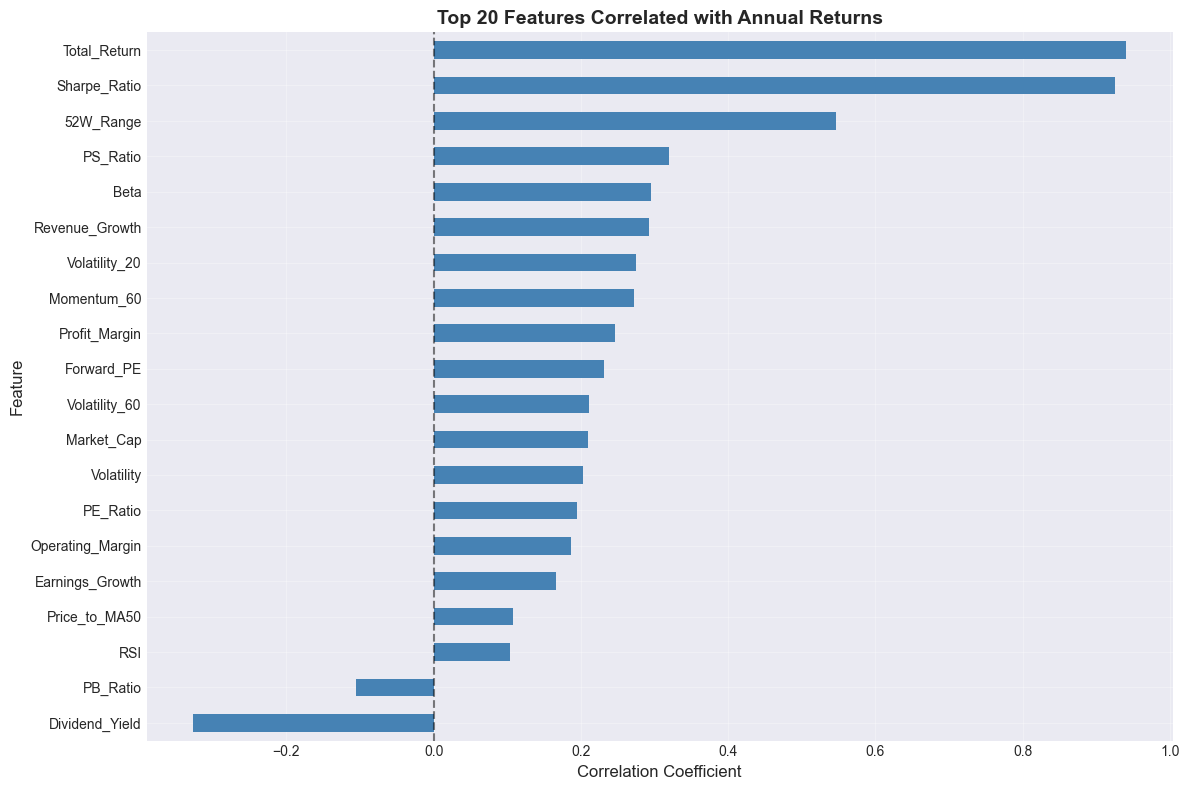

In [13]:
# Visualize correlation with returns
top_correlations = correlations_with_returns.drop('Annual_Return').abs().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
correlations_with_returns[top_correlations.index].sort_values().plot(kind='barh', color='steelblue')
plt.title('Top 20 Features Correlated with Annual Returns', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

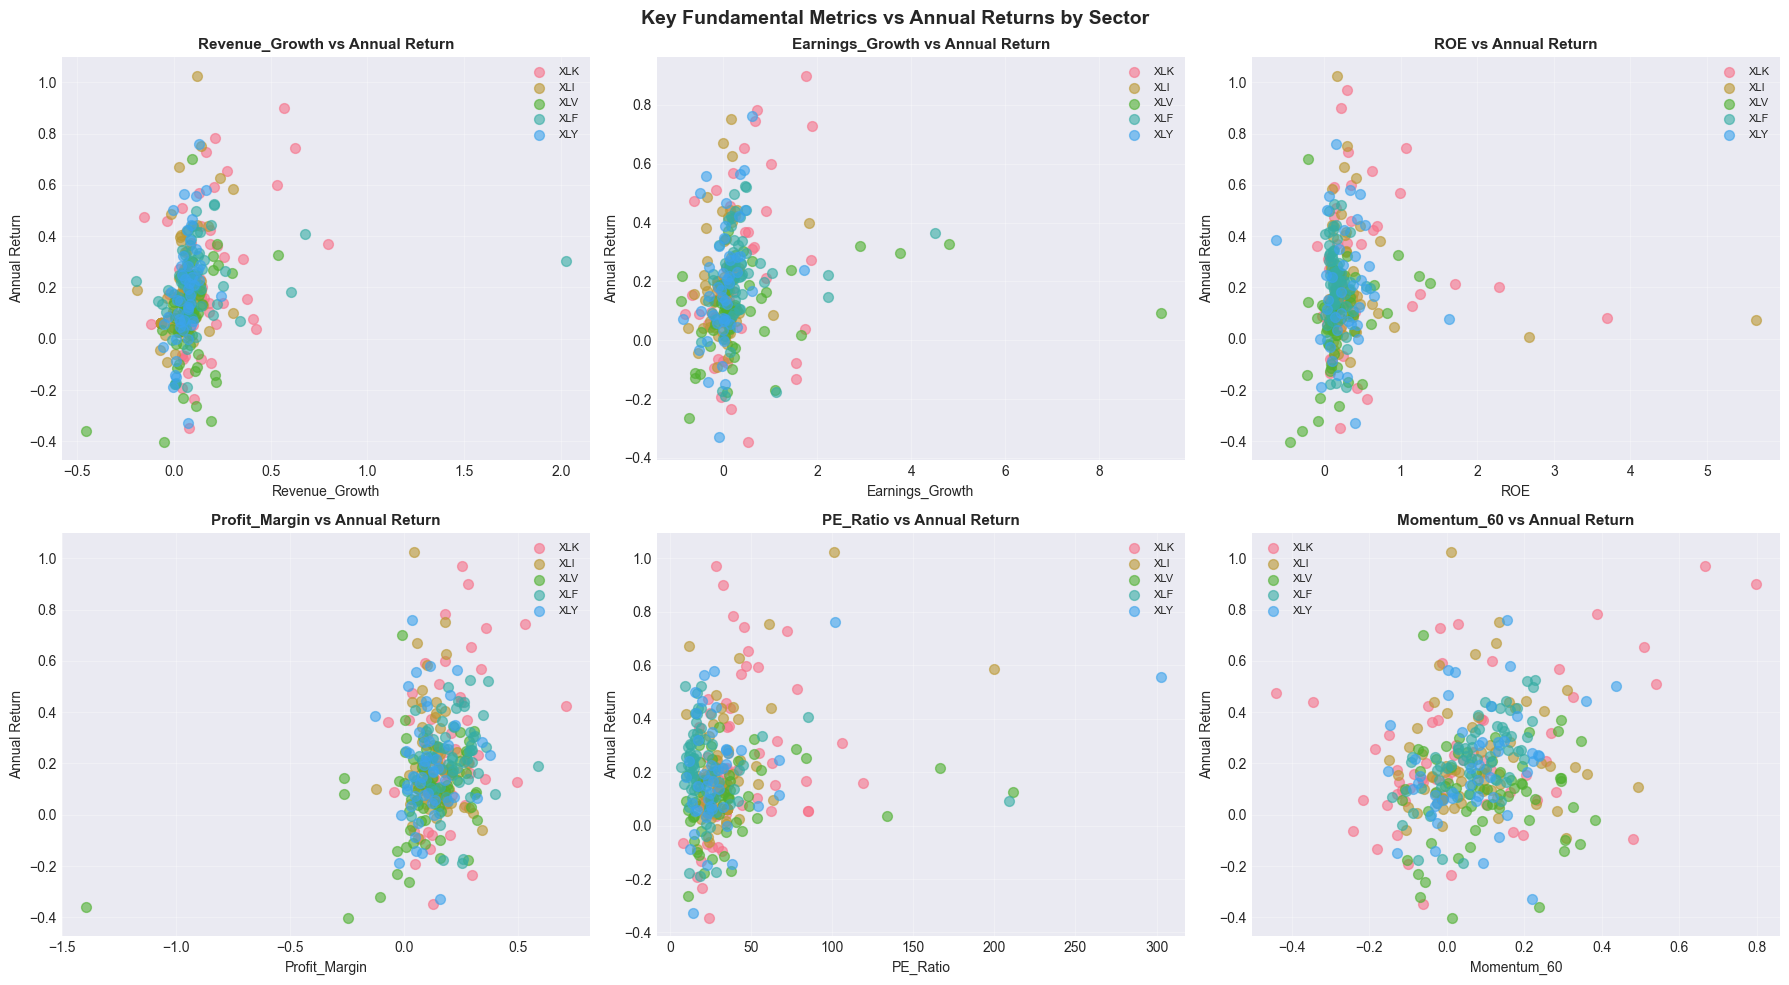

In [14]:
# Scatter plots of key fundamental metrics vs returns
key_fundamentals = ['Revenue_Growth', 'Earnings_Growth', 'ROE', 'Profit_Margin', 'PE_Ratio', 'Momentum_60']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_fundamentals):
    if feature in full_features_df.columns:
        ax = axes[idx]
        
        # Plot by sector
        for sector in full_features_df['Sector_Code'].unique():
            sector_data = full_features_df[full_features_df['Sector_Code'] == sector]
            ax.scatter(sector_data[feature], sector_data['Annual_Return'], 
                      label=sector, alpha=0.6, s=50)
        
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel('Annual Return', fontsize=10)
        ax.set_title(f'{feature} vs Annual Return', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

plt.suptitle('Key Fundamental Metrics vs Annual Returns by Sector', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Clustering Analysis

Group stocks with similar characteristics using K-Means and DBSCAN

In [15]:
# Prepare data for clustering - select key features and handle missing values
clustering_features = ['Market_Cap', 'PE_Ratio', 'PB_Ratio', 'ROE', 'Profit_Margin', 
                       'Revenue_Growth', 'Earnings_Growth', 'Beta', 
                       'Momentum_60', 'Volatility_60', 'RSI']

# Filter to stocks with sufficient data
clustering_df = full_features_df[['Symbol', 'Sector', 'Sector_Code'] + clustering_features].copy()
clustering_df = clustering_df.dropna(subset=clustering_features)

print(f"Stocks with complete data for clustering: {len(clustering_df)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df[clustering_features])

print(f"Scaled feature matrix shape: {X_scaled.shape}")

Stocks with complete data for clustering: 262
Scaled feature matrix shape: (262, 11)


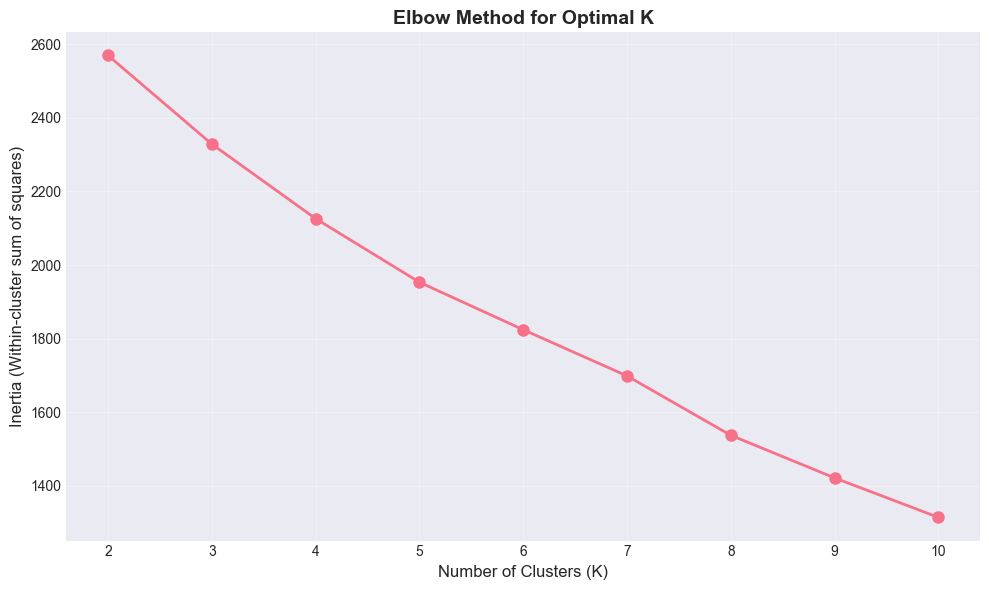

In [16]:
# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Apply K-Means clustering
optimal_k = 5  # Based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"K-Means clustering with K={optimal_k}")
print(f"\nCluster distribution:")
print(clustering_df['Cluster'].value_counts().sort_index())

K-Means clustering with K=5

Cluster distribution:
Cluster
0    136
1      4
2     17
3    104
4      1
Name: count, dtype: int64



Cluster Characteristics (Mean Values):
           Market_Cap  PE_Ratio  PB_Ratio    ROE  Profit_Margin  \
Cluster                                                           
0        7.976467e+10    31.117     6.242  0.203          0.155   
1        3.634783e+12    37.357    26.678  0.838          0.317   
2        3.733872e+11    64.229    11.821  0.315          0.241   
3        7.915165e+10    30.053     8.231  0.369          0.159   
4        1.451309e+10    17.729  -184.362  5.639          0.109   

         Revenue_Growth  Earnings_Growth   Beta  Momentum_60  Volatility_60  \
Cluster                                                                       
0                 0.050            0.066  1.222        0.120          0.311   
1                 0.256            0.518  1.464        0.038          0.258   
2                 0.342            1.324  1.394        0.112          0.423   
3                 0.086            0.206  0.826       -0.001          0.237   
4               

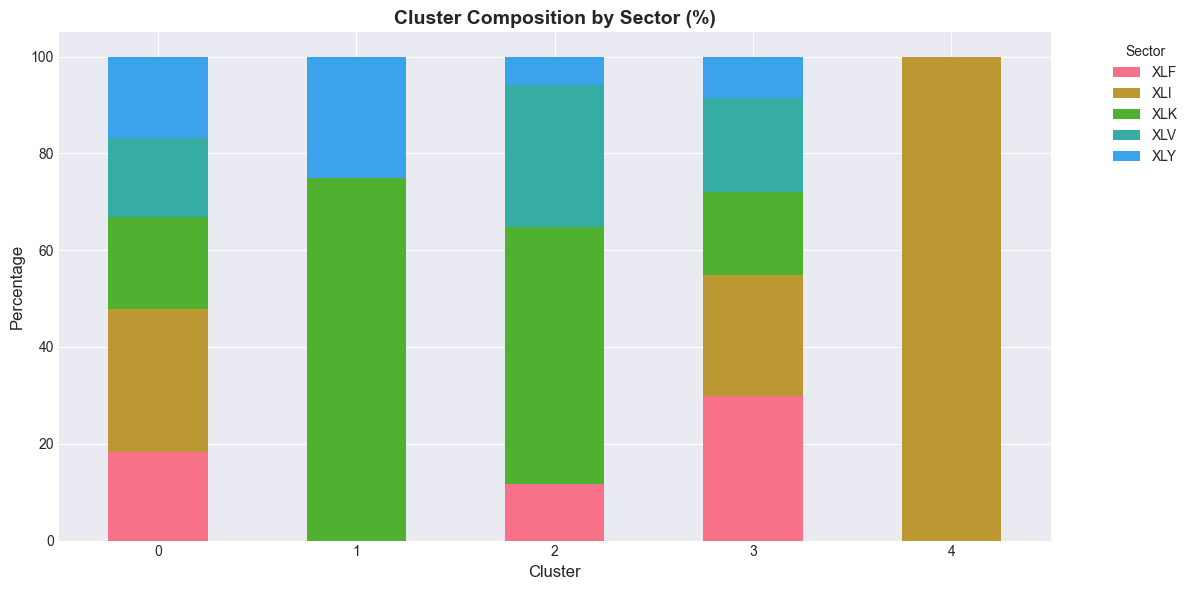

In [18]:
# Analyze cluster characteristics
cluster_summary = clustering_df.groupby('Cluster')[clustering_features].mean()
print("\nCluster Characteristics (Mean Values):")
print(cluster_summary.round(3))

# Visualize cluster composition by sector
cluster_sector = pd.crosstab(clustering_df['Cluster'], clustering_df['Sector_Code'], normalize='index') * 100

plt.figure(figsize=(12, 6))
cluster_sector.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Cluster Composition by Sector (%)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Dimensionality Reduction (PCA)

Reduce feature space and visualize stock relationships

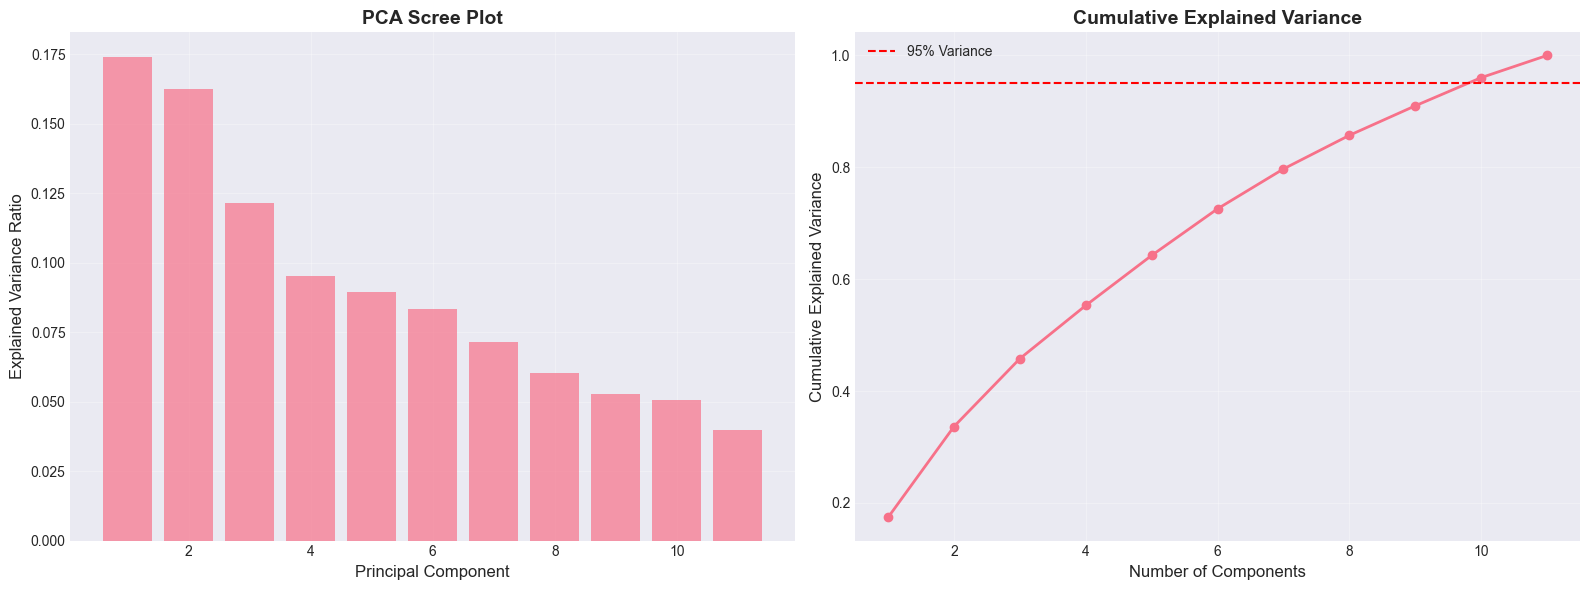


First 5 components explain 64.24% of variance
Components needed for 95% variance: 10


In [19]:
# Apply PCA
pca = PCA()
pca_features = pca.fit_transform(X_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scree plot
ax1.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 5 components explain {cumulative_variance[4]:.2%} of variance")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")

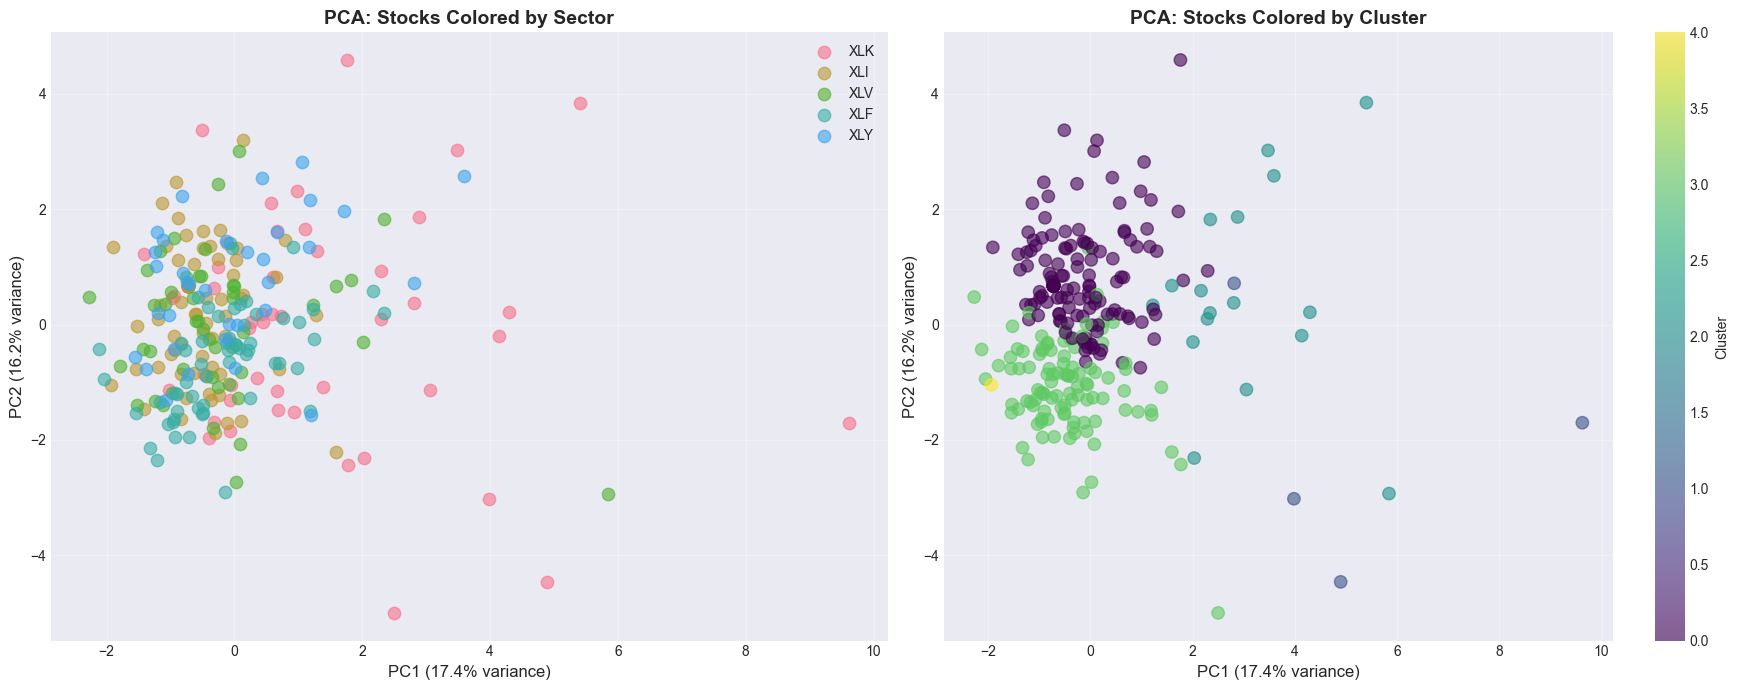

In [20]:
# Visualize stocks in 2D PCA space
clustering_df['PC1'] = pca_features[:, 0]
clustering_df['PC2'] = pca_features[:, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Color by sector
for sector in clustering_df['Sector_Code'].unique():
    sector_data = clustering_df[clustering_df['Sector_Code'] == sector]
    ax1.scatter(sector_data['PC1'], sector_data['PC2'], label=sector, alpha=0.6, s=80)

ax1.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax1.set_title('PCA: Stocks Colored by Sector', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Color by cluster
scatter = ax2.scatter(clustering_df['PC1'], clustering_df['PC2'], 
                     c=clustering_df['Cluster'], cmap='viridis', alpha=0.6, s=80)
ax2.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)', fontsize=12)
ax2.set_title('PCA: Stocks Colored by Cluster', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Loadings on First 3 Principal Components:
                   PC1    PC2    PC3
Market_Cap       0.450 -0.150 -0.104
PE_Ratio         0.193  0.222 -0.477
PB_Ratio         0.275 -0.123 -0.011
ROE              0.135 -0.238 -0.180
Profit_Margin    0.361 -0.264  0.267
Revenue_Growth   0.492 -0.089  0.065
Earnings_Growth  0.331 -0.162  0.356
Beta             0.307  0.396 -0.289
Momentum_60      0.121  0.368  0.527
Volatility_60    0.272  0.470 -0.170
RSI             -0.023  0.490  0.369


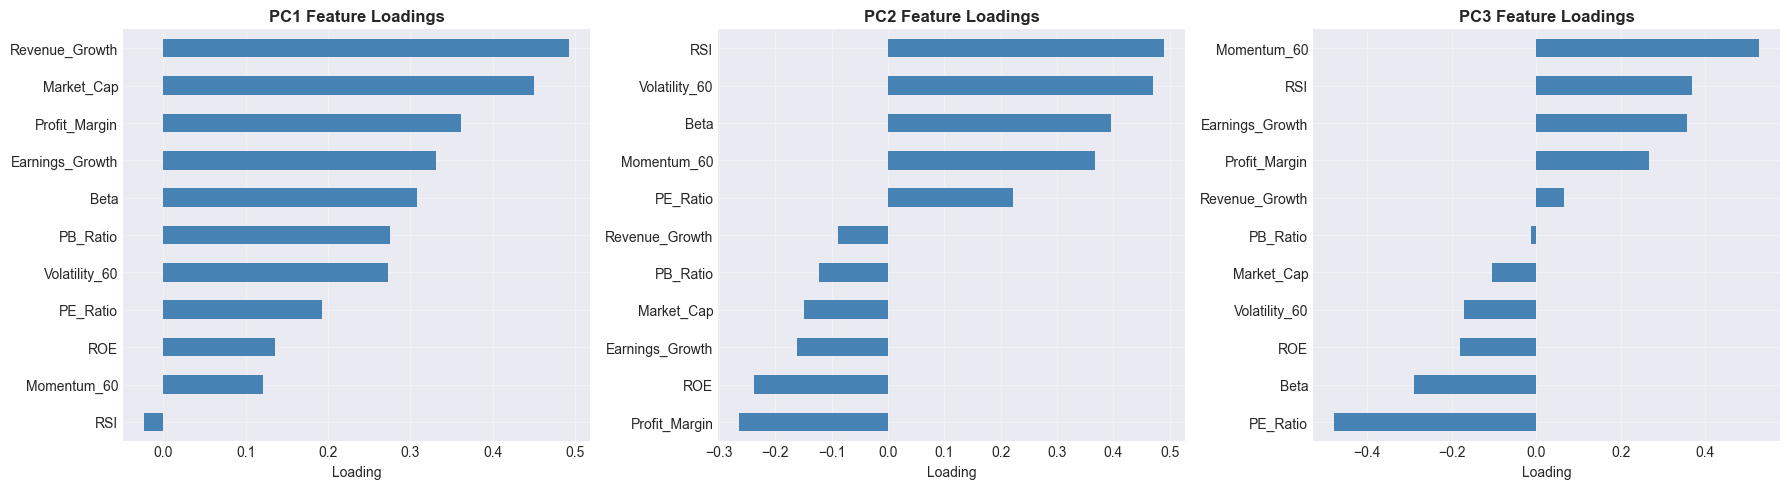

In [21]:
# Feature contributions to principal components
loadings = pd.DataFrame(
    pca.components_[:3, :].T,
    columns=['PC1', 'PC2', 'PC3'],
    index=clustering_features
)

print("Feature Loadings on First 3 Principal Components:")
print(loadings.round(3))

# Visualize loadings
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, pc in enumerate(['PC1', 'PC2', 'PC3']):
    loadings[pc].sort_values().plot(kind='barh', ax=axes[idx], color='steelblue')
    axes[idx].set_title(f'{pc} Feature Loadings', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Loading', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Predictive Modeling

Build models to predict stock returns based on fundamentals and technical features

In [22]:
# Prepare modeling dataset
model_features = ['Market_Cap', 'PE_Ratio', 'PB_Ratio', 'ROE', 'ROA', 'Profit_Margin',
                  'Operating_Margin', 'Revenue_Growth', 'Earnings_Growth', 'Beta',
                  'Debt_to_Equity', 'Dividend_Yield', 
                  'MA_20', 'MA_50', 'Price_to_MA20', 'Price_to_MA50',
                  'Momentum_20', 'Momentum_60', 'Volatility_20', 'Volatility_60', 'RSI']

target = 'Annual_Return'

# Filter to stocks with complete data
model_df = full_features_df[['Symbol'] + model_features + [target]].dropna()

print(f"Modeling dataset: {len(model_df)} stocks with complete data")
print(f"Features: {len(model_features)}")

X = model_df[model_features]
y = model_df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set: {len(X_train)} stocks")
print(f"Test set: {len(X_test)} stocks")

Modeling dataset: 189 stocks with complete data
Features: 21

Training set: 151 stocks
Test set: 38 stocks


In [23]:
# Scale features
scaler_model = StandardScaler()
X_train_scaled = scaler_model.fit_transform(X_train)
X_test_scaled = scaler_model.transform(X_test)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results[name] = {
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Predictions': y_test_pred
    }
    
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}\n")

print("Model training complete!")

Training models...

Training Linear Regression...
  Train R²: 0.5274
  Test R²: -0.9223
  Test RMSE: 0.2379
  Test MAE: 0.1388

Training Ridge Regression...
  Train R²: 0.5206
  Test R²: -1.3189
  Test RMSE: 0.2613
  Test MAE: 0.1441

Training Lasso Regression...
  Train R²: 0.5155
  Test R²: 0.1065
  Test RMSE: 0.1622
  Test MAE: 0.1193

Training Random Forest...
  Train R²: 0.9213
  Test R²: 0.4554
  Test RMSE: 0.1266
  Test MAE: 0.0866

Training Gradient Boosting...
  Train R²: 1.0000
  Test R²: 0.3545
  Test RMSE: 0.1378
  Test MAE: 0.0957

Model training complete!


Model Performance Comparison:
                   Train R²   Test R² Test RMSE  Test MAE
Linear Regression  0.527448  -0.92235  0.237881  0.138777
Ridge Regression   0.520625 -1.318868  0.261265  0.144051
Lasso Regression   0.515524  0.106485  0.162179  0.119296
Random Forest      0.921286   0.45536  0.126619  0.086596
Gradient Boosting  0.999955  0.354524  0.137843  0.095707


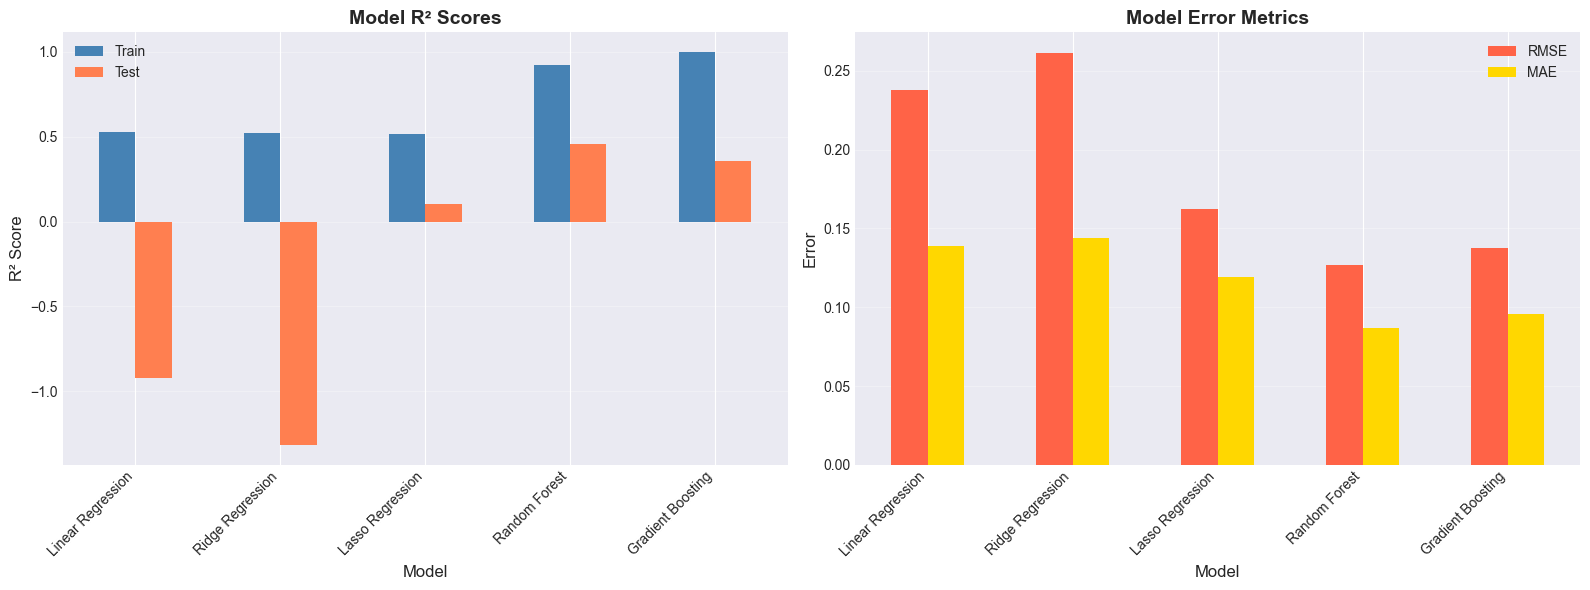

In [24]:
# Compare model performance
results_df = pd.DataFrame(results).T
results_df = results_df.drop('Predictions', axis=1)

print("Model Performance Comparison:")
print(results_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² scores
results_df[['Train R²', 'Test R²']].plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Model R² Scores', fontsize=14, fontweight='bold')
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(['Train', 'Test'])
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Error metrics
results_df[['Test RMSE', 'Test MAE']].plot(kind='bar', ax=axes[1], color=['tomato', 'gold'])
axes[1].set_title('Model Error Metrics', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].legend(['RMSE', 'MAE'])
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

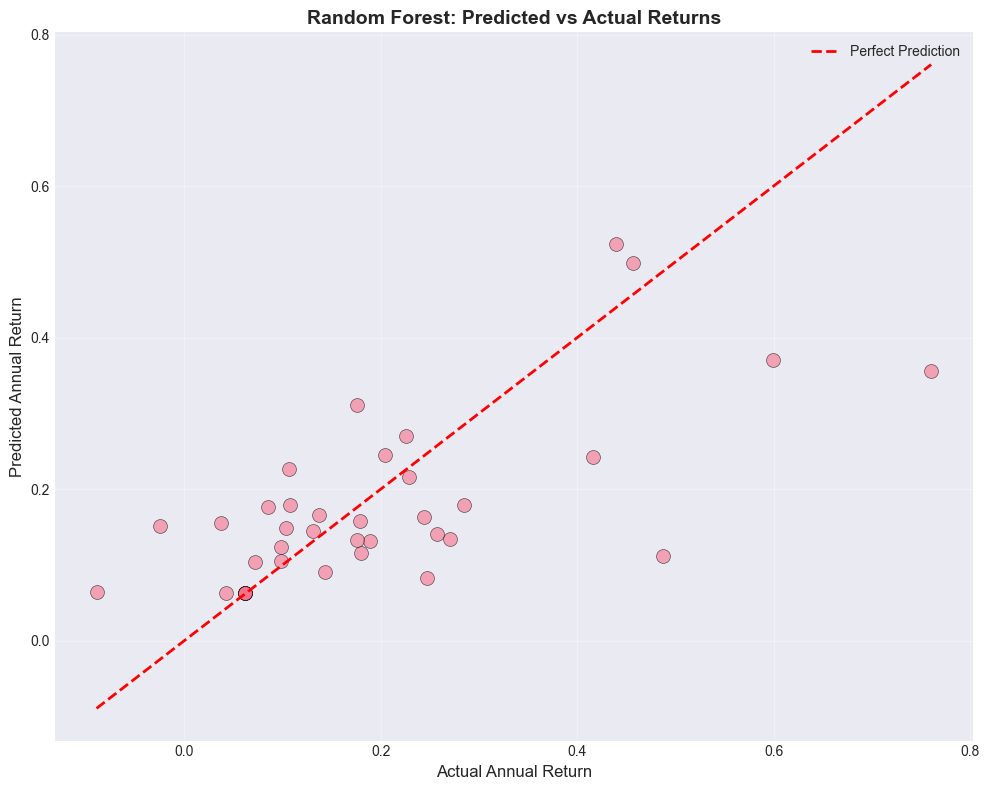

Best model: Random Forest
Test R²: 0.4554


In [25]:
# Plot predictions vs actual for best model
best_model_name = results_df['Test R²'].idxmax()
best_predictions = results[best_model_name]['Predictions']

plt.figure(figsize=(10, 8))
plt.scatter(y_test, best_predictions, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Annual Return', fontsize=12)
plt.ylabel('Predicted Annual Return', fontsize=12)
plt.title(f'{best_model_name}: Predicted vs Actual Returns', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Best model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['Test R²']:.4f}")

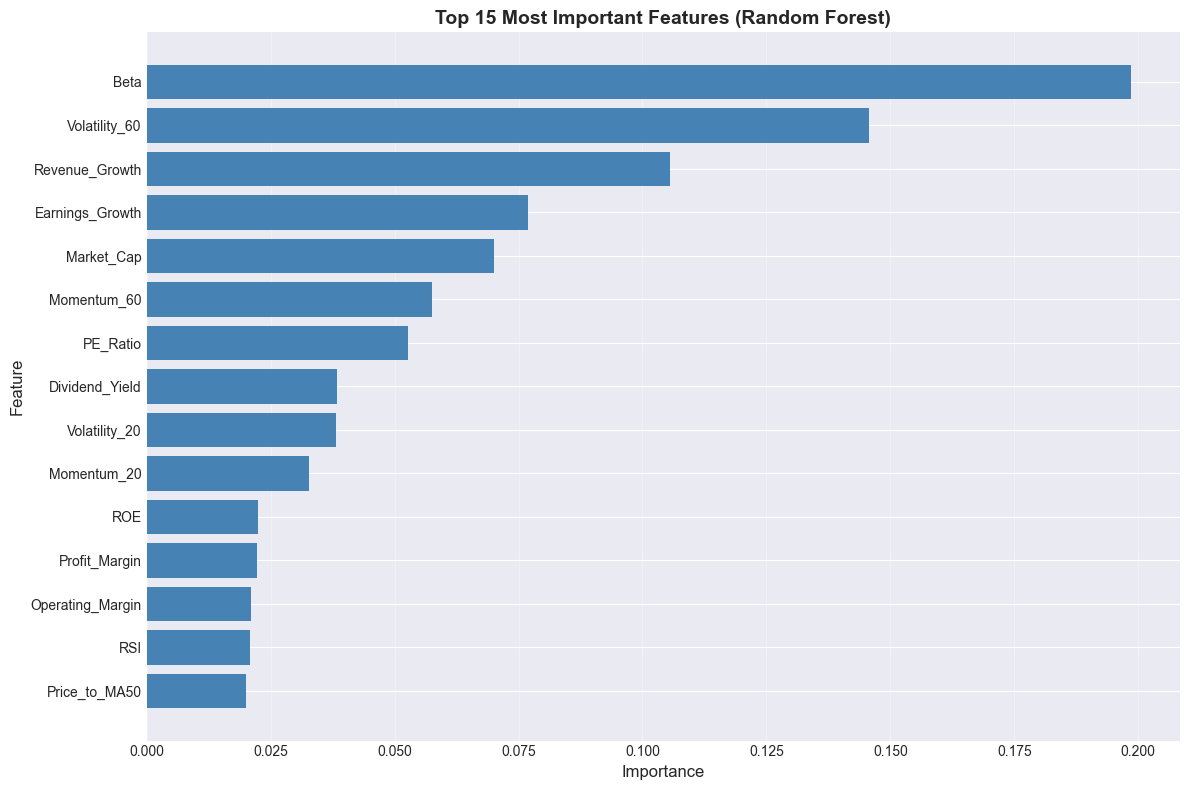


Top 10 Most Important Features:
            Feature  Importance
9              Beta    0.198495
19    Volatility_60    0.145763
7    Revenue_Growth    0.105534
8   Earnings_Growth    0.076928
0        Market_Cap    0.069969
17      Momentum_60    0.057502
1          PE_Ratio    0.052785
11   Dividend_Yield    0.038407
18    Volatility_20    0.038170
16      Momentum_20    0.032825


In [26]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15), color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## 8. Sector Deep Dive Comparison

In [27]:
# Comprehensive sector comparison
sector_analysis = full_features_df.groupby('Sector_Code').agg({
    'Annual_Return': ['mean', 'std', 'min', 'max'],
    'Volatility': ['mean', 'std'],
    'Sharpe_Ratio': ['mean', 'std'],
    'PE_Ratio': ['mean', 'median'],
    'PB_Ratio': ['mean', 'median'],
    'ROE': ['mean', 'median'],
    'Profit_Margin': ['mean', 'median'],
    'Revenue_Growth': ['mean', 'median'],
    'Beta': ['mean', 'median'],
    'Symbol': 'count'
}).round(4)

sector_analysis.columns = ['_'.join(col).strip() for col in sector_analysis.columns.values]
sector_analysis = sector_analysis.rename(columns={'Symbol_count': 'Stock_Count'})

print("Comprehensive Sector Analysis:")
print(sector_analysis)

Comprehensive Sector Analysis:
             Annual_Return_mean  Annual_Return_std  Annual_Return_min  \
Sector_Code                                                             
XLF                      0.2184             0.1535            -0.1897   
XLI                      0.1968             0.1986            -0.0895   
XLK                      0.2156             0.2651            -0.3464   
XLV                      0.0781             0.1876            -0.4032   
XLY                      0.1867             0.2154            -0.3285   

             Annual_Return_max  Volatility_mean  Volatility_std  \
Sector_Code                                                       
XLF                     0.5238           0.2633          0.0580   
XLI                     1.0255           0.2849          0.0750   
XLK                     0.9709           0.3821          0.1345   
XLV                     0.7018           0.3290          0.1166   
XLY                     0.7606           0.3341        

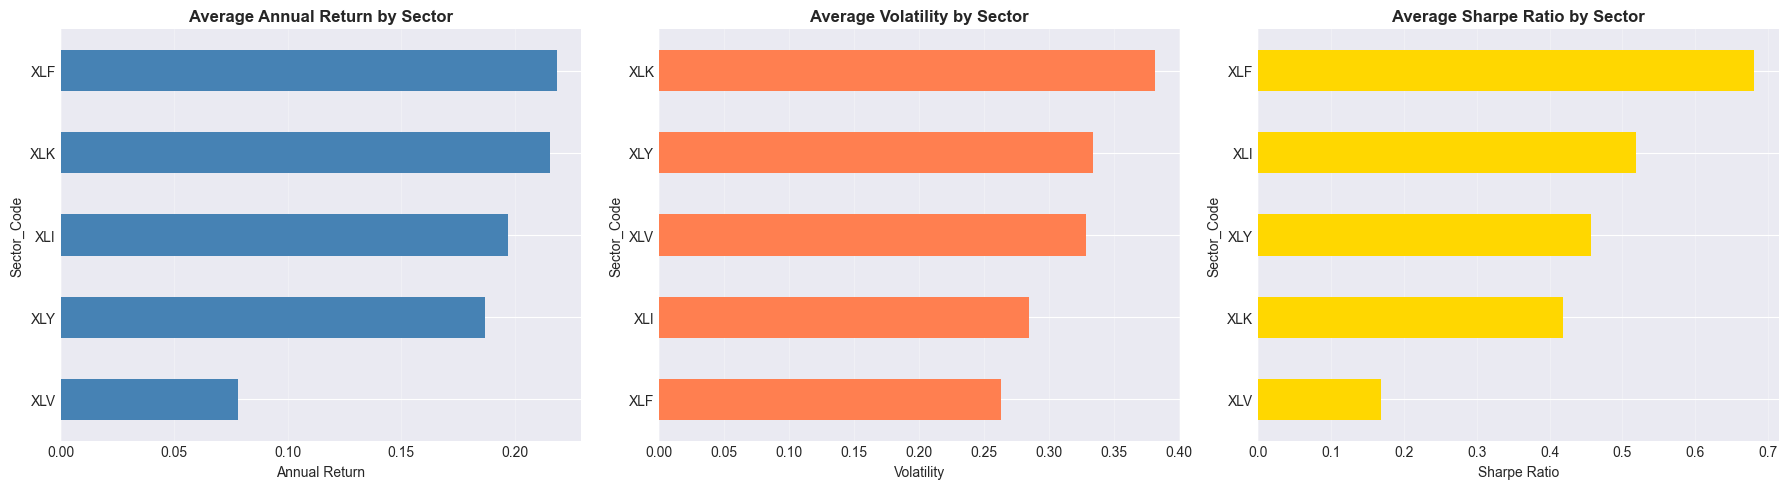

In [28]:
# Visualize sector performance metrics
sector_metrics = full_features_df.groupby('Sector_Code')[['Annual_Return', 'Volatility', 'Sharpe_Ratio']].mean()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Annual Return
sector_metrics['Annual_Return'].sort_values().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Average Annual Return by Sector', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Annual Return', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')

# Volatility
sector_metrics['Volatility'].sort_values().plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Average Volatility by Sector', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Volatility', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='x')

# Sharpe Ratio
sector_metrics['Sharpe_Ratio'].sort_values().plot(kind='barh', ax=axes[2], color='gold')
axes[2].set_title('Average Sharpe Ratio by Sector', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Sharpe Ratio', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

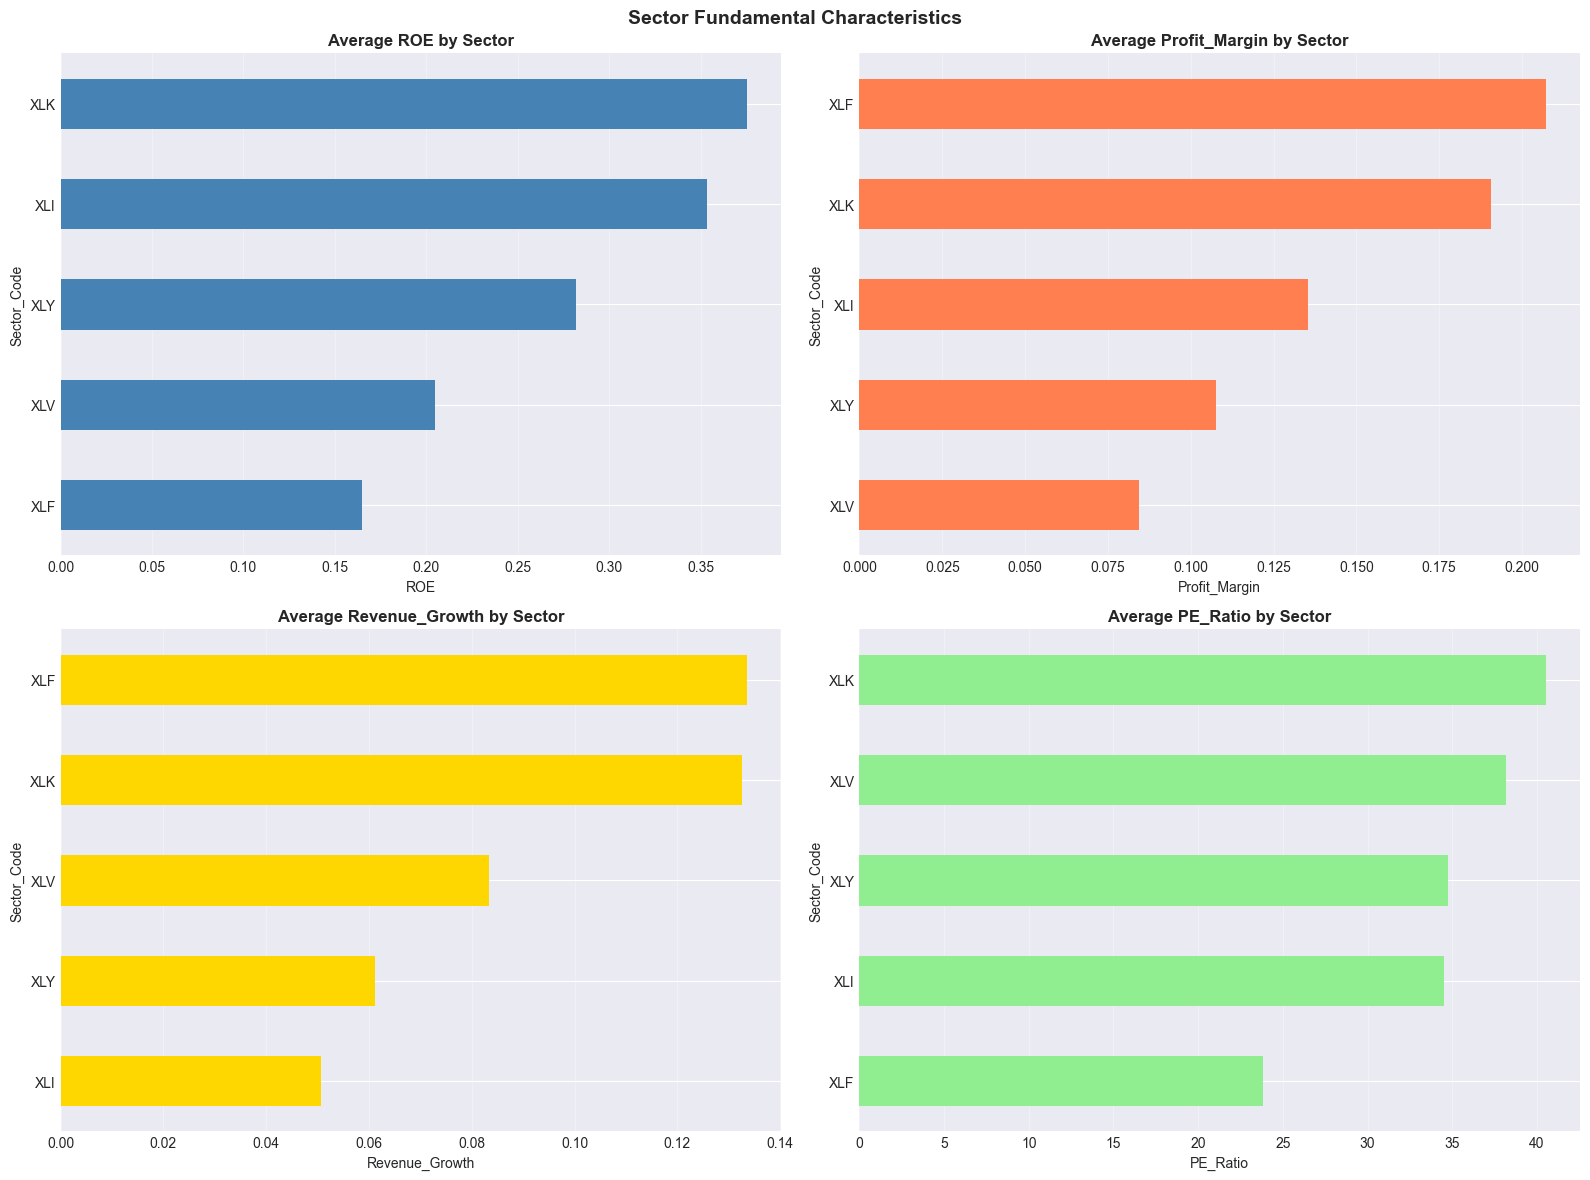

In [29]:
# Sector fundamental characteristics
sector_fundamentals = full_features_df.groupby('Sector_Code')[['ROE', 'Profit_Margin', 'Revenue_Growth', 'PE_Ratio']].mean()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['ROE', 'Profit_Margin', 'Revenue_Growth', 'PE_Ratio']
colors = ['steelblue', 'coral', 'gold', 'lightgreen']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    sector_fundamentals[metric].sort_values().plot(kind='barh', ax=axes[idx], color=color)
    axes[idx].set_title(f'Average {metric} by Sector', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(metric, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.suptitle('Sector Fundamental Characteristics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

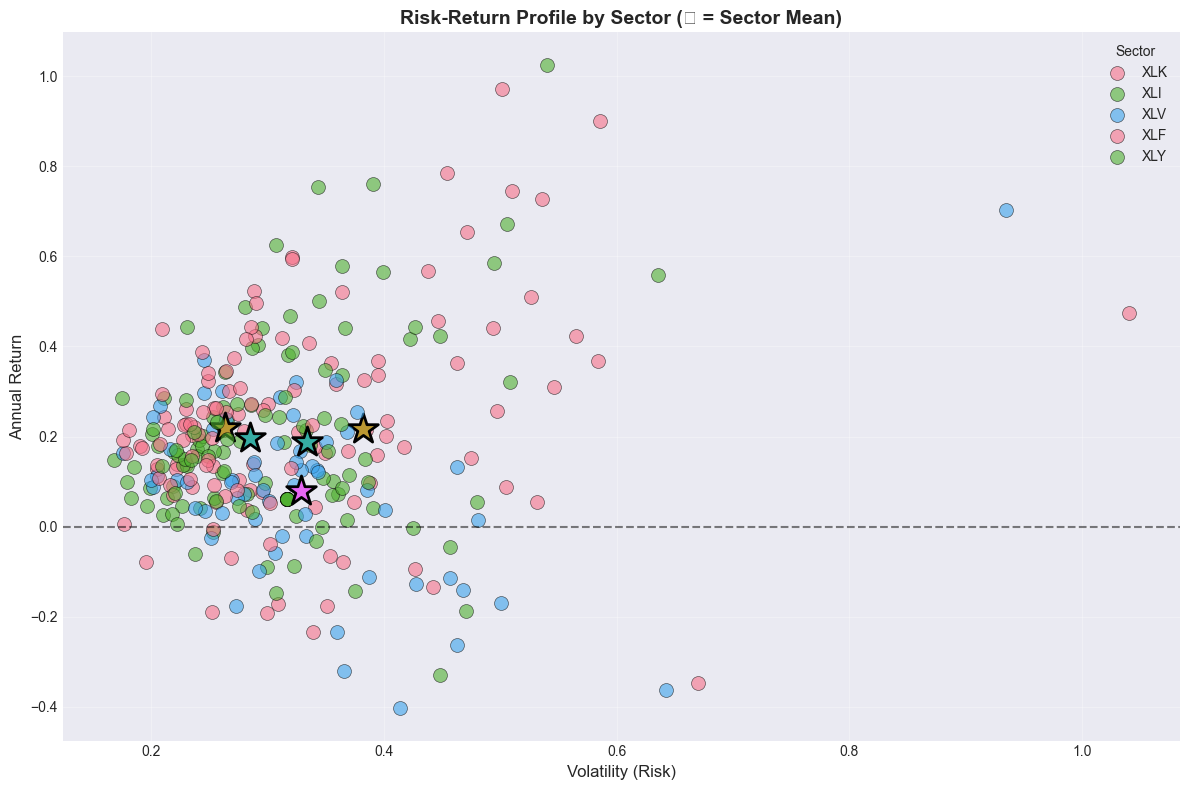

In [30]:
# Risk-return profile by sector
plt.figure(figsize=(12, 8))

for sector in full_features_df['Sector_Code'].unique():
    sector_data = full_features_df[full_features_df['Sector_Code'] == sector]
    plt.scatter(sector_data['Volatility'], sector_data['Annual_Return'], 
               label=sector, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Add sector mean
    mean_vol = sector_data['Volatility'].mean()
    mean_ret = sector_data['Annual_Return'].mean()
    plt.scatter(mean_vol, mean_ret, s=500, marker='*', edgecolors='black', linewidth=2)

plt.xlabel('Volatility (Risk)', fontsize=12)
plt.ylabel('Annual Return', fontsize=12)
plt.title('Risk-Return Profile by Sector (★ = Sector Mean)', fontsize=14, fontweight='bold')
plt.legend(title='Sector', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 9. Key Insights and Summary

In [31]:
# Generate summary insights
print("="*80)
print("KEY INSIGHTS FROM ADVANCED ANALYSIS")
print("="*80)

print("\n1. CORRELATION ANALYSIS:")
print("   Top 3 features correlated with returns:")
for i, (feature, corr) in enumerate(correlations_with_returns.drop('Annual_Return').head(3).items(), 1):
    print(f"   {i}. {feature}: {corr:.3f}")

print("\n2. CLUSTERING:")
print(f"   Identified {optimal_k} distinct stock clusters")
print("   Clusters show mixed sector composition, indicating cross-sector similarities")

print("\n3. DIMENSIONALITY REDUCTION:")
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"   {n_components_95} principal components explain 95% of variance")
print(f"   First component explains {explained_variance[0]:.1%} of variation")

print("\n4. PREDICTIVE MODELING:")
print(f"   Best model: {best_model_name}")
print(f"   Test R²: {results[best_model_name]['Test R²']:.4f}")
print(f"   Test RMSE: {results[best_model_name]['Test RMSE']:.4f}")

print("\n5. SECTOR COMPARISON:")
best_sector = sector_metrics['Sharpe_Ratio'].idxmax()
worst_sector = sector_metrics['Sharpe_Ratio'].idxmin()
print(f"   Best risk-adjusted returns: {best_sector} (Sharpe: {sector_metrics.loc[best_sector, 'Sharpe_Ratio']:.3f})")
print(f"   Worst risk-adjusted returns: {worst_sector} (Sharpe: {sector_metrics.loc[worst_sector, 'Sharpe_Ratio']:.3f})")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

KEY INSIGHTS FROM ADVANCED ANALYSIS

1. CORRELATION ANALYSIS:
   Top 3 features correlated with returns:
   1. Total_Return: 0.940
   2. Sharpe_Ratio: 0.926
   3. 52W_Range: 0.546

2. CLUSTERING:
   Identified 5 distinct stock clusters
   Clusters show mixed sector composition, indicating cross-sector similarities

3. DIMENSIONALITY REDUCTION:
   10 principal components explain 95% of variance
   First component explains 17.4% of variation

4. PREDICTIVE MODELING:
   Best model: Random Forest
   Test R²: 0.4554
   Test RMSE: 0.1266

5. SECTOR COMPARISON:
   Best risk-adjusted returns: XLF (Sharpe: 0.681)
   Worst risk-adjusted returns: XLV (Sharpe: 0.169)

ANALYSIS COMPLETE


## 10. Save Results

In [32]:
# Save all analysis results
full_features_df.to_csv('full_features_dataset.csv', index=False)
print("Full features dataset saved to 'full_features_dataset.csv'")

clustering_df.to_csv('clustering_results.csv', index=False)
print("Clustering results saved to 'clustering_results.csv'")

sector_analysis.to_csv('sector_detailed_analysis.csv')
print("Sector analysis saved to 'sector_detailed_analysis.csv'")

results_df.to_csv('model_performance_comparison.csv')
print("Model performance saved to 'model_performance_comparison.csv'")

print("\nAll results saved successfully!")

Full features dataset saved to 'full_features_dataset.csv'
Clustering results saved to 'clustering_results.csv'
Sector analysis saved to 'sector_detailed_analysis.csv'
Model performance saved to 'model_performance_comparison.csv'

All results saved successfully!
